In [26]:
import pandas as pd
from scipy.io import arff
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Load the ARFF file
data, meta = arff.loadarff('KDDTrain+.arff')

# Convert to a pandas DataFrame
df = pd.DataFrame(data)

# If you have byte-string columns, you can decode them:
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode('utf-8')


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  float64
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  float64
 5   dst_bytes                    125973 non-null  float64
 6   land                         125973 non-null  object 
 7   wrong_fragment               125973 non-null  float64
 8   urgent                       125973 non-null  float64
 9   hot                          125973 non-null  float64
 10  num_failed_logins            125973 non-null  float64
 11  logged_in                    125973 non-null  object 
 12  num_compromised              125973 non-null  float64
 13 

### Convertion of Columns to Numeric

In [29]:
# convert ceratin columns to numeric
df['is_host_login'] = pd.to_numeric(df['is_host_login'], errors='coerce')
df['is_guest_login'] = pd.to_numeric(df['is_guest_login'], errors='coerce')
df['logged_in'] = pd.to_numeric(df['logged_in'], errors='coerce')
df['land'] = pd.to_numeric(df['land'], errors='coerce')

# convert class column to numeric anamoly as 1 and normal as 0
df['class'] = df['class'].replace({
    'normal': 0,
    'anomaly': 1
})

/tmp/ipykernel_1468964/3749963743.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace({


In [30]:
# check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
Series([], dtype: int64)


In [31]:
# Distribution of the target variable
print("\nDistribution of the target variable:")
print(df['class'].value_counts(normalize=True))


Distribution of the target variable:
class
0    0.534583
1    0.465417
Name: proportion, dtype: float64


### Checking Distribution of Numeric Columns and Cardinality of Columns

In [32]:
# find columns with less no.of unique values
low_cardinality_cols = [col for col in df.columns if df[col].nunique() < 10]
print("\nLow cardinality columns:")
print(low_cardinality_cols)

# print distribution of low cardinality columns
for col in low_cardinality_cols:
    print(f"\nDistribution of {col}:")
    print(df[col].value_counts(normalize=True))


Low cardinality columns:
['protocol_type', 'land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'logged_in', 'root_shell', 'su_attempted', 'num_shells', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'class']

Distribution of protocol_type:
protocol_type
tcp     0.815167
udp     0.119018
icmp    0.065816
Name: proportion, dtype: float64

Distribution of land:
land
0    0.999802
1    0.000198
Name: proportion, dtype: float64

Distribution of wrong_fragment:
wrong_fragment
0.0    0.991347
3.0    0.007017
1.0    0.001635
Name: proportion, dtype: float64

Distribution of urgent:
urgent
0.0    0.999929
1.0    0.000040
2.0    0.000024
3.0    0.000008
Name: proportion, dtype: float64

Distribution of num_failed_logins:
num_failed_logins
0.0    0.999032
1.0    0.000826
2.0    0.000071
3.0    0.000040
4.0    0.000024
5.0    0.000008
Name: proportion, dtype: float64

Distribution of logged_in:
logged_in
0    0.604264
1    0.395736
Name: proportion, dtype: float64

Distribution of r

In [33]:
# Checking rarely occurring values in low cardinality columns
low_cardinality_cols.remove('class')

for col in low_cardinality_cols:
    unique_values = df[col].unique()
    for value in unique_values:
        class_distribution = df[df[col] == value]['class'].value_counts(normalize=True)
        if class_distribution.size == 1:
            print(f"\nDistribution of {col} = {value}:")
            print(class_distribution)


Distribution of wrong_fragment = 3.0:
class
1    1.0
Name: proportion, dtype: float64

Distribution of wrong_fragment = 1.0:
class
1    1.0
Name: proportion, dtype: float64

Distribution of urgent = 3.0:
class
0    1.0
Name: proportion, dtype: float64

Distribution of num_failed_logins = 2.0:
class
0    1.0
Name: proportion, dtype: float64

Distribution of num_failed_logins = 3.0:
class
0    1.0
Name: proportion, dtype: float64

Distribution of num_failed_logins = 5.0:
class
1    1.0
Name: proportion, dtype: float64

Distribution of su_attempted = 2.0:
class
0    1.0
Name: proportion, dtype: float64

Distribution of is_host_login = 1:
class
0    1.0
Name: proportion, dtype: float64


In [34]:
# find columns with no.of unique values as 1
single_value_cols = [col for col in df.columns if df[col].nunique() == 1]
print("\nColumns with a single unique value:")
print(single_value_cols)


Columns with a single unique value:
['num_outbound_cmds']


In [35]:
# drop columns with a single unique value
if single_value_cols:
    print(f"Dropping columns with a single unique value: {single_value_cols}")
    # Drop the columns 
    try: 
        df.drop(columns=single_value_cols, inplace=True)
    except KeyError as e:
        print(f"Error dropping columns: {e}")

Dropping columns with a single unique value: ['num_outbound_cmds']


### Conversion of Categorical Columns to Numeric

In [36]:
# Convert categorical variables to numeric
df_encoded = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])
df_encoded['src_dst_bytes'] = df['src_bytes'] * df['dst_bytes']

In [37]:
# correlation matrix
corr_matrix = df_encoded.corr()
target_corr = corr_matrix['class'].sort_values(ascending=False)
high_corr_pairs = target_corr[target_corr > 0.5]
print("\nHighly correlated pairs with target variable:")
print(high_corr_pairs)


Highly correlated pairs with target variable:
class                       1.000000
dst_host_srv_serror_rate    0.654985
dst_host_serror_rate        0.651842
serror_rate                 0.650652
flag_S0                     0.650206
srv_serror_rate             0.648289
count                       0.576444
Name: class, dtype: float64


### PCA

In [38]:
# find pairs of features with high correlation
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
high_corr_pairs = upper_tri[(upper_tri > 0.8) | (upper_tri < -0.8)]
print("\nHighly correlated pairs:")
print(high_corr_pairs[high_corr_pairs != 1].stack().reset_index())


Highly correlated pairs:
                     level_0                   level_1         0
0                        hot            is_guest_login  0.860288
1            num_compromised                  num_root  0.998833
2             is_guest_login               service_ftp  0.820069
3                serror_rate           srv_serror_rate  0.993289
4                serror_rate      dst_host_serror_rate  0.979373
5                serror_rate  dst_host_srv_serror_rate  0.981139
6                serror_rate                   flag_S0  0.979174
7            srv_serror_rate      dst_host_serror_rate  0.977596
8            srv_serror_rate  dst_host_srv_serror_rate  0.986252
9            srv_serror_rate                   flag_S0  0.982660
10               rerror_rate           srv_rerror_rate  0.989008
11               rerror_rate      dst_host_rerror_rate  0.926749
12               rerror_rate  dst_host_srv_rerror_rate  0.964449
13               rerror_rate                  flag_REJ  0.835068

In [39]:
# Apply PCA on two groups of features
group1 = ['rerror_rate', 'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_rerror_rate', 'flag_REJ']
group2 = ['serror_rate', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_serror_rate', 'flag_S0']

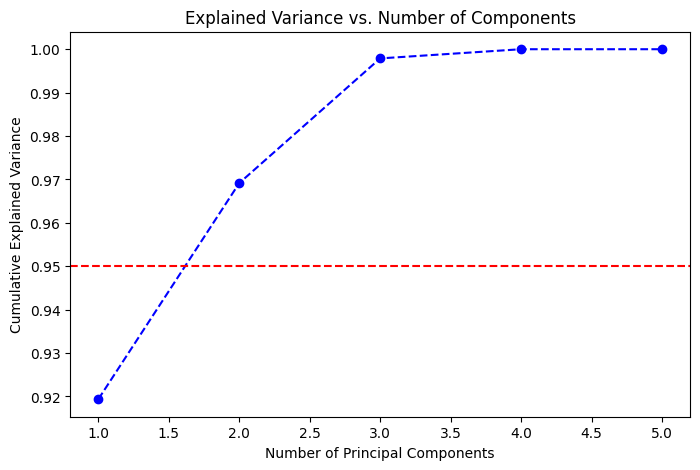

Optimal number of components: 2


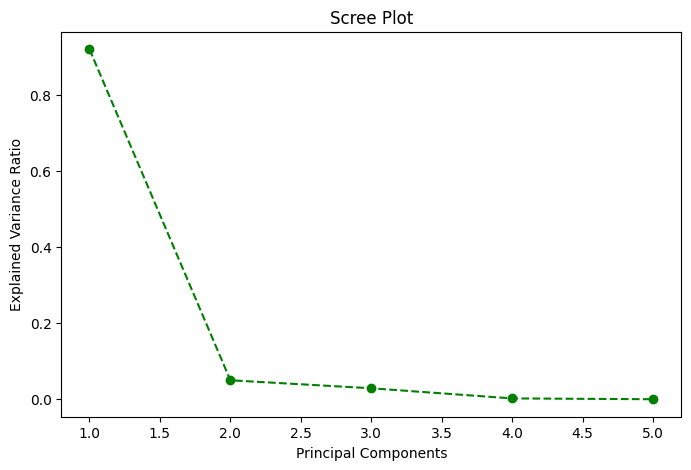

Optimal number of components based on Kaiser Criterion: 1


In [40]:
# Find the optimal number of components for PCA
group1 = ['rerror_rate', 'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_rerror_rate', 'flag_REJ']

X = df_encoded[group1]

X_scaled = StandardScaler().fit_transform(X)

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Compute cumulative explained variance
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_var_exp) + 1), cum_var_exp, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% variance threshold
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

# Find the best n_components
best_n = np.argmax(cum_var_exp >= 0.95) + 1
print(f"Optimal number of components: {best_n}")

# Elbow method to find the optimal number of components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--', color='g')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

best_n = np.sum(pca.explained_variance_ > 1)
print(f"Optimal number of components based on Kaiser Criterion: {best_n}")


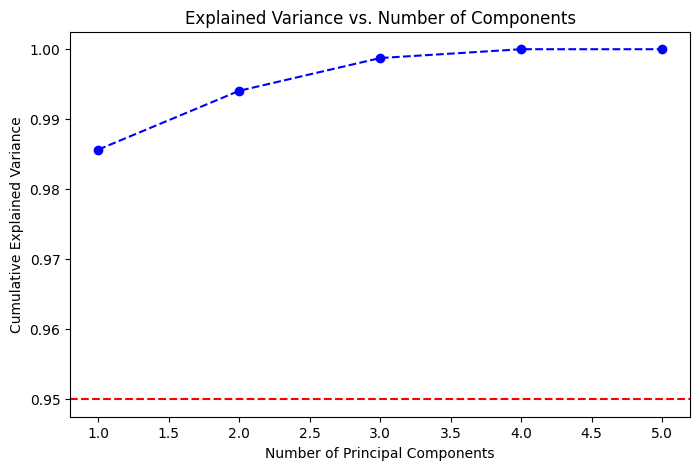

Optimal number of components: 1


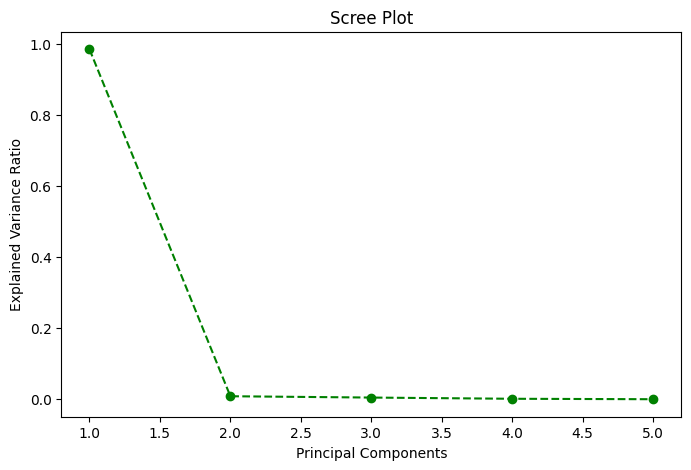

Optimal number of components based on Kaiser Criterion: 1


In [41]:
# Find the optimal number of components for PCA
group2 = ['serror_rate', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_serror_rate', 'flag_S0']

X = df_encoded[group2]

X_scaled = StandardScaler().fit_transform(X)

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Compute cumulative explained variance
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_var_exp) + 1), cum_var_exp, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% variance threshold
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

# Find the best n_components
best_n = np.argmax(cum_var_exp >= 0.95) + 1
print(f"Optimal number of components: {best_n}")


# Elbow method to find the optimal number of components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--', color='g')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

best_n = np.sum(pca.explained_variance_ > 1)
print(f"Optimal number of components based on Kaiser Criterion: {best_n}")


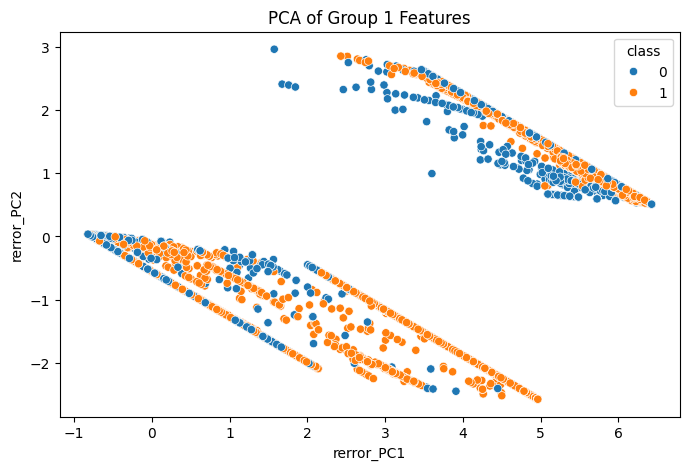

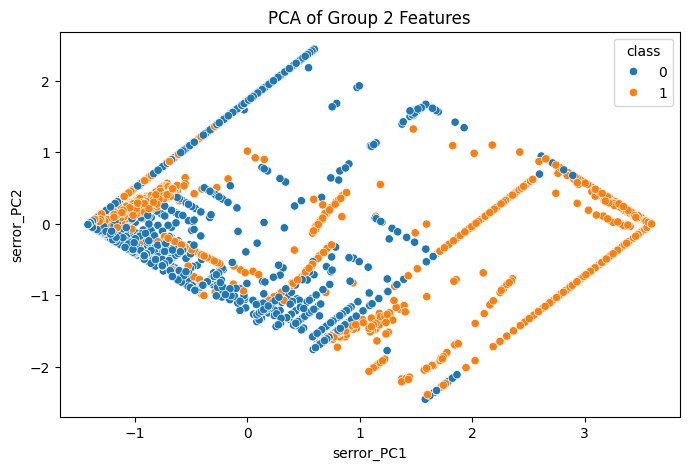

In [42]:
# Based on plots decide the number of components as 2 for both groups
pca_group1 = PCA(n_components=2)
X_group1 = df_encoded[group1]
group1_scaler = StandardScaler()
X_group1_scaled = group1_scaler.fit_transform(X_group1)
pca_group1.fit(X_group1_scaled)

X_group1_pca = pca_group1.transform(X_group1_scaled)
pca_df_group1 = pd.DataFrame(data=X_group1_pca, columns=['rerror_PC1', 'rerror_PC2'])

pca_df_group1['class'] = df_encoded['class'].values
plt.figure(figsize=(8, 5))
sns.scatterplot(x='rerror_PC1', y='rerror_PC2', hue='class', data=pca_df_group1)
plt.title('PCA of Group 1 Features')
plt.show()

pca_group2 = PCA(n_components=2)
X_group2 = df_encoded[group2]
group2_scaler = StandardScaler()
X_group2_scaled = group2_scaler.fit_transform(X_group2)
pca_group2.fit(X_group2_scaled)

X_group2_pca = pca_group2.transform(X_group2_scaled)
pca_df_group2 = pd.DataFrame(data=X_group2_pca, columns=['serror_PC1', 'serror_PC2'])

pca_df_group2['class'] = df_encoded['class'].values
plt.figure(figsize=(8, 5))
sns.scatterplot(x='serror_PC1', y='serror_PC2', hue='class', data=pca_df_group2)
plt.title('PCA of Group 2 Features')
plt.show()

In [43]:
# drop group1 and group2 columns
df_encoded.drop(columns=group1 + group2, inplace=True)

# add PCA columns to the dataframe
df_encoded = pd.concat([df_encoded, pca_df_group1.drop(columns='class'), pca_df_group2.drop(columns='class')], axis=1)

## Plots

In [44]:
df_encoded.to_csv('processed_temp.csv', index=False)

In [45]:
df_encoded = pd.read_csv('processed_temp.csv')

### Box Plots

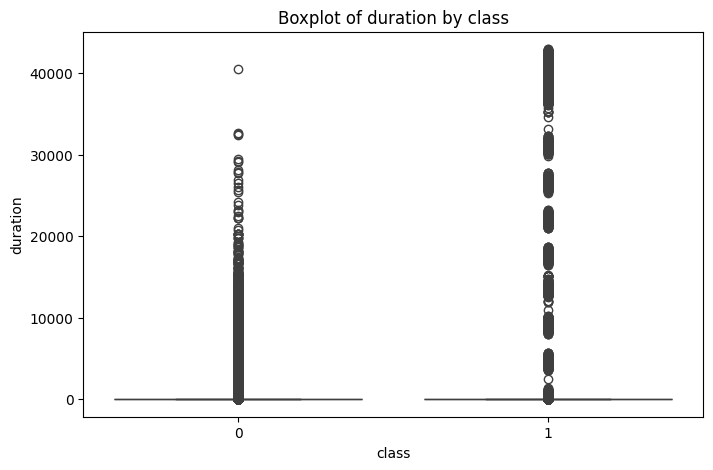

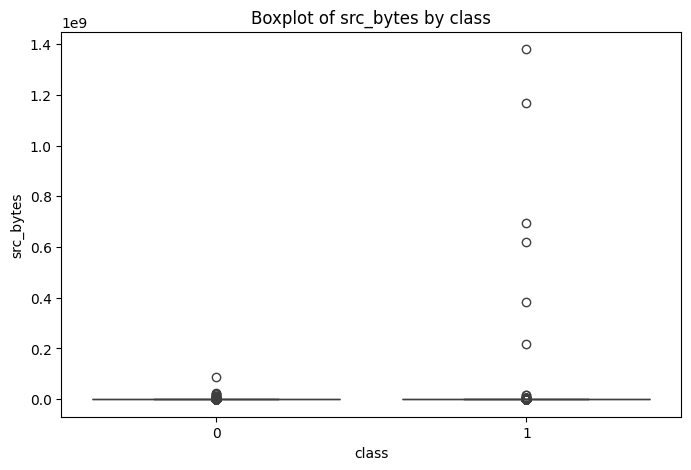

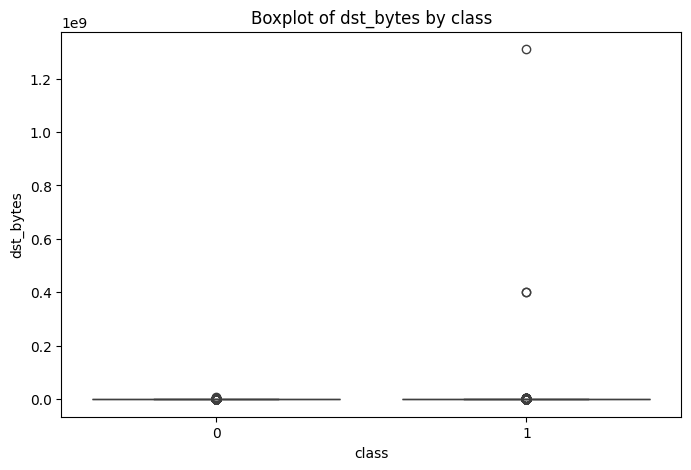

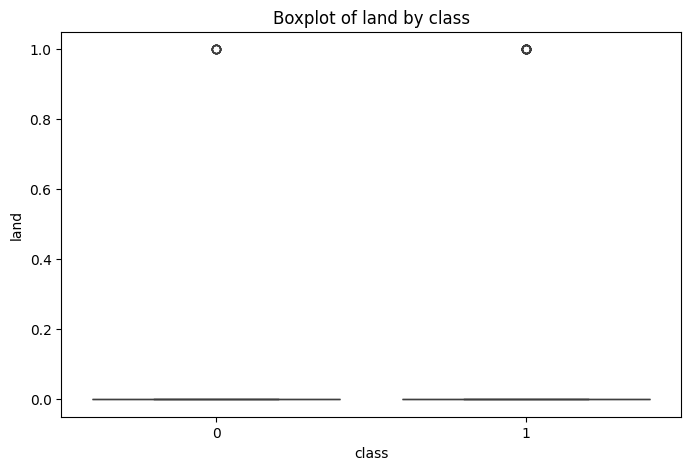

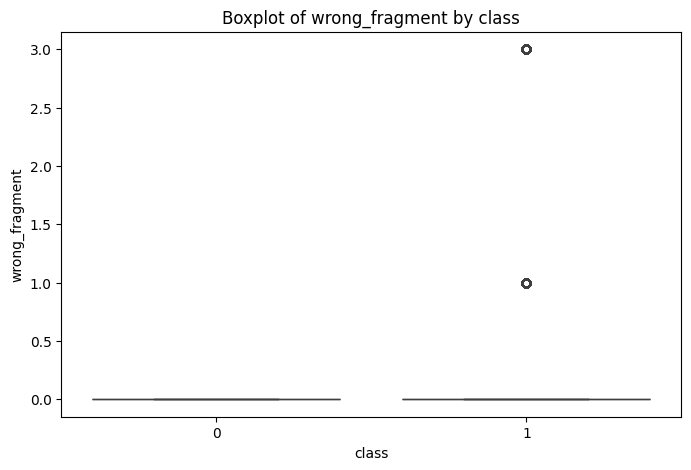

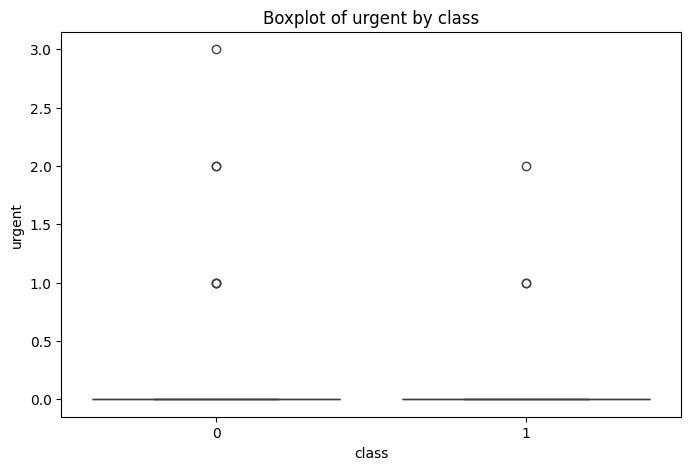

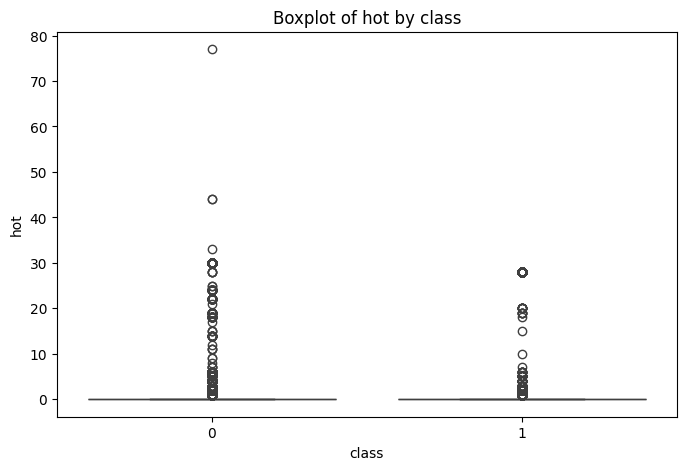

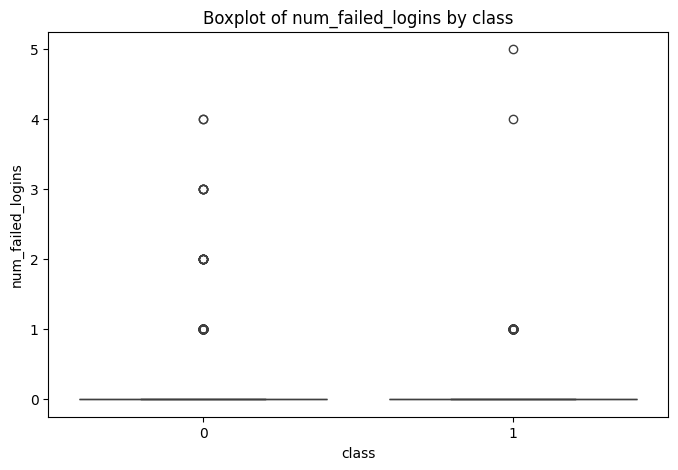

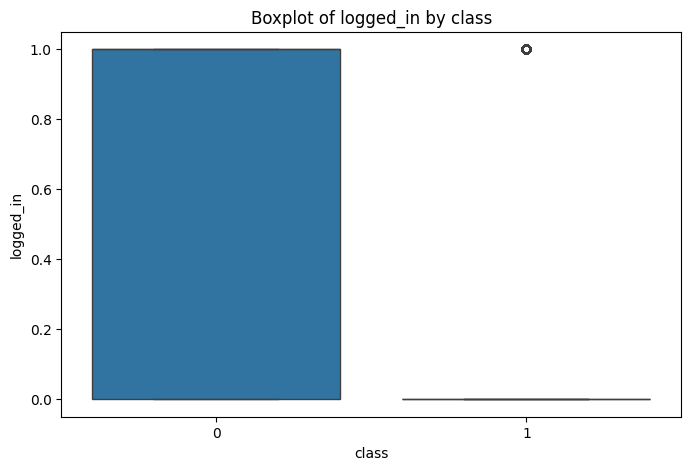

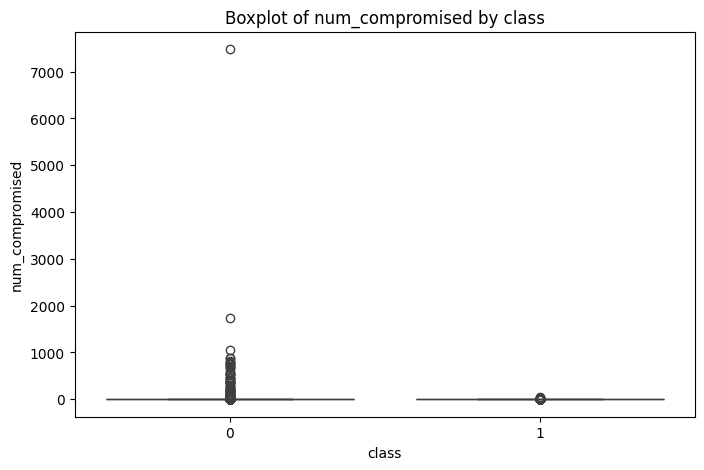

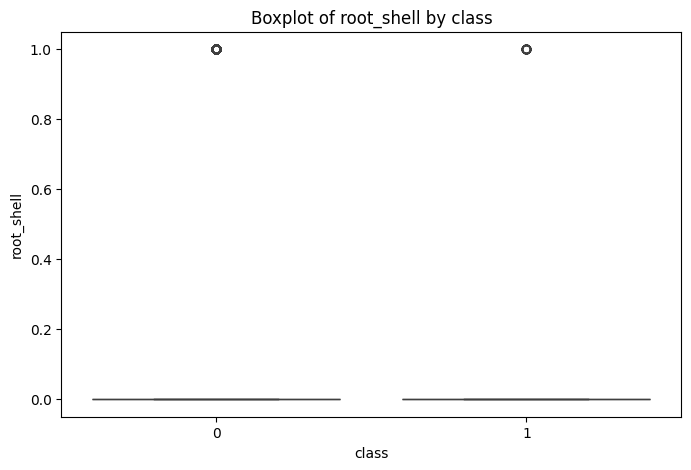

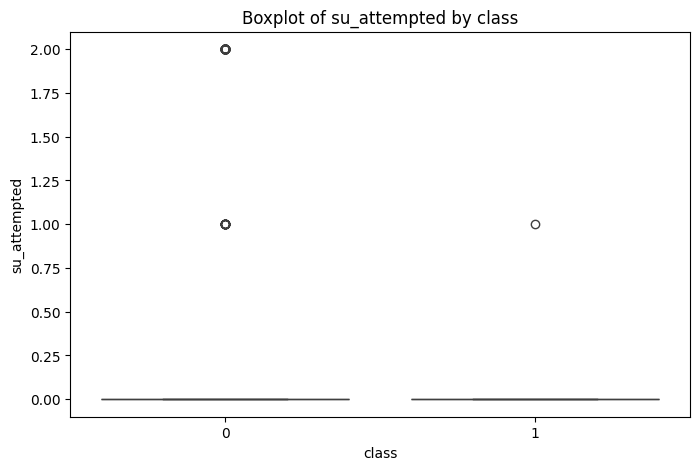

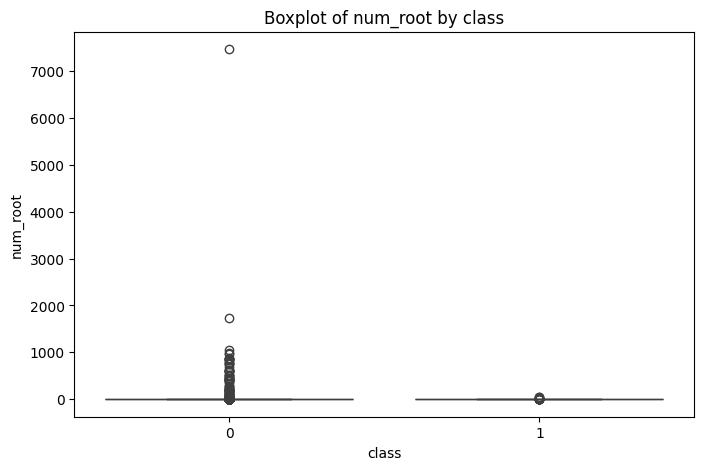

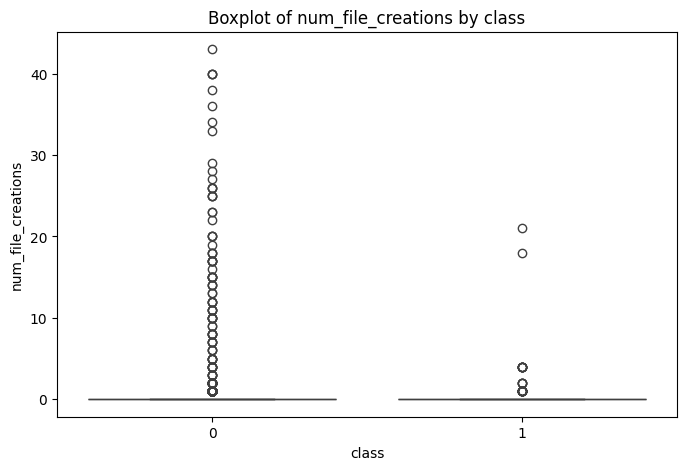

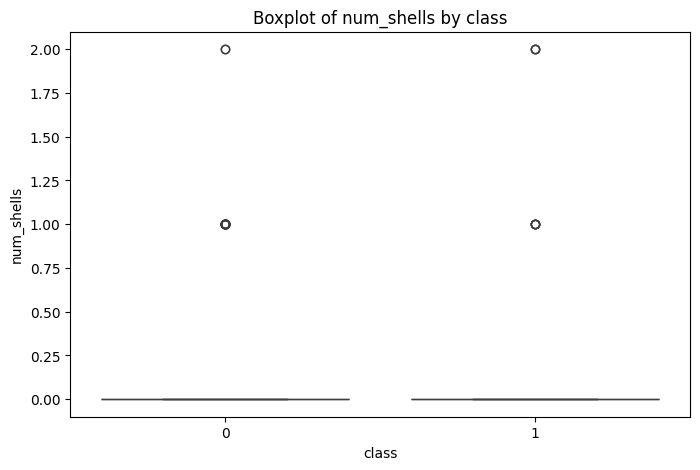

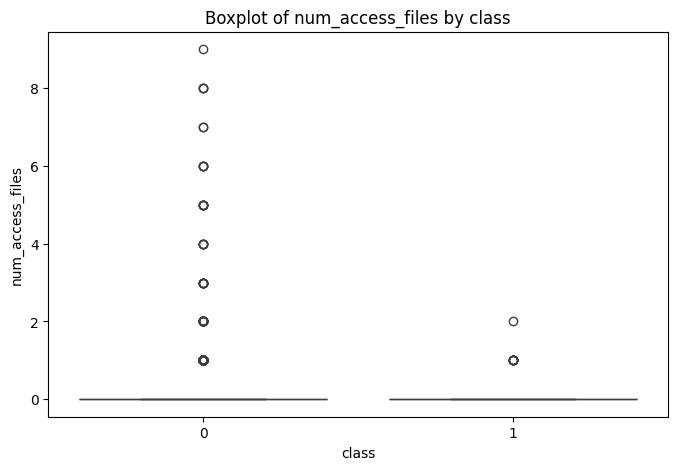

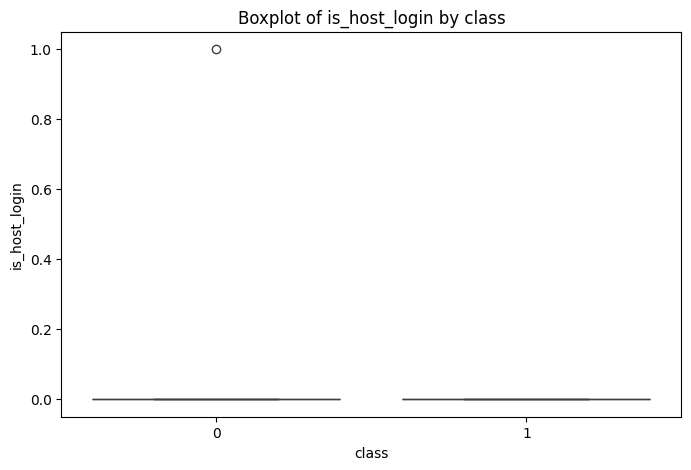

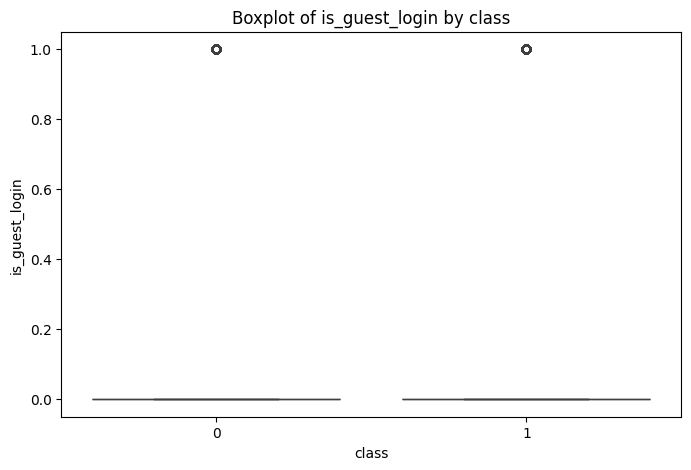

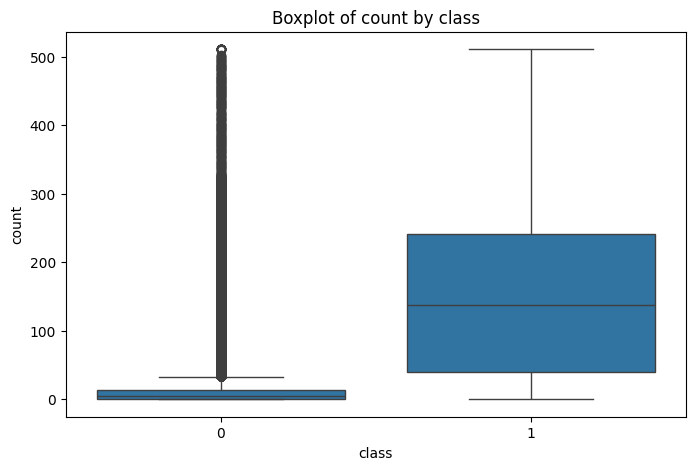

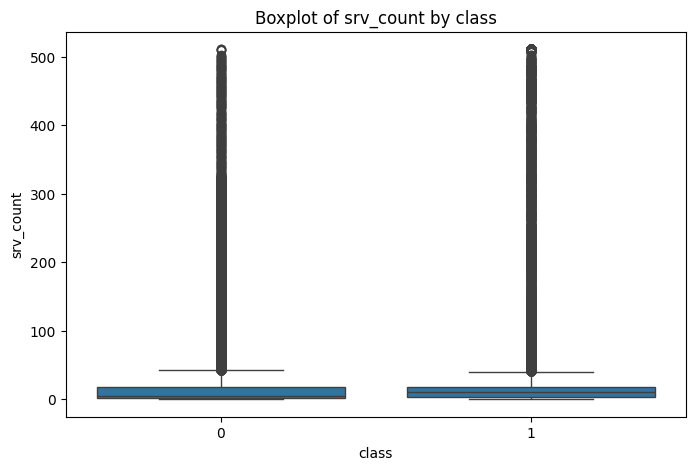

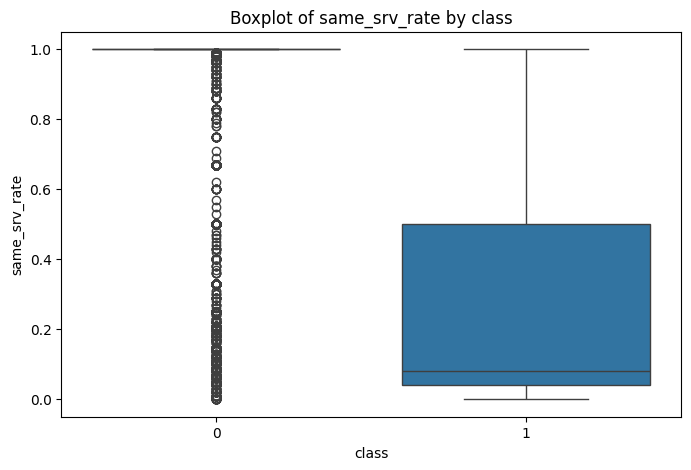

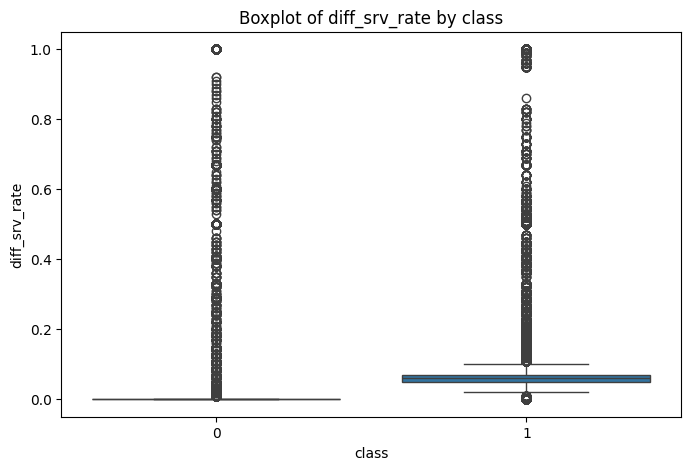

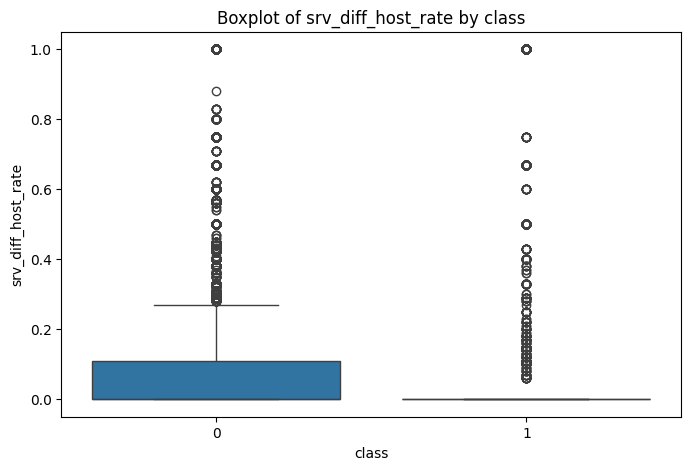

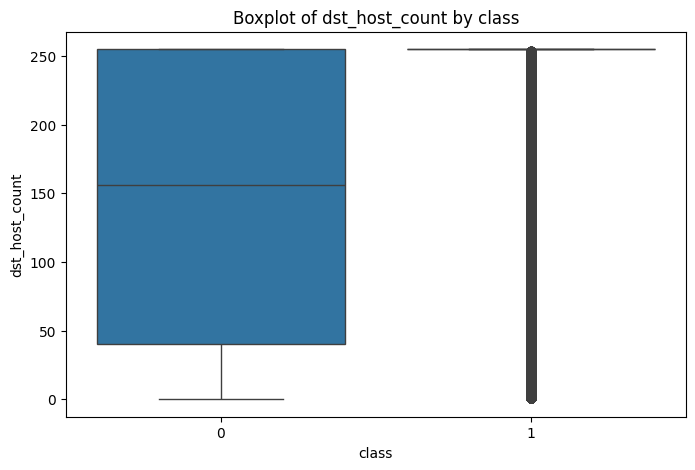

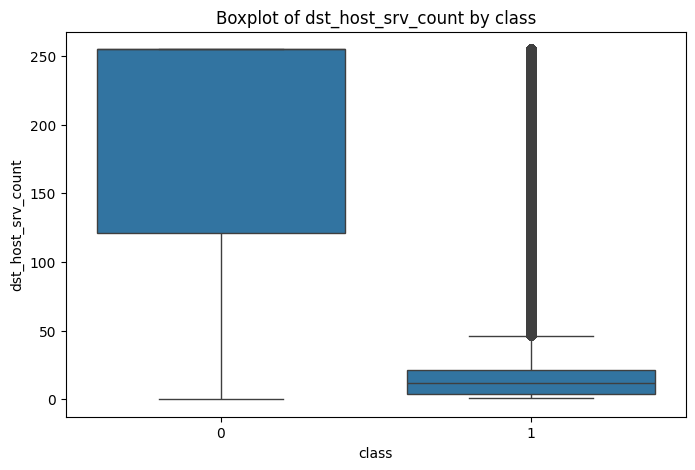

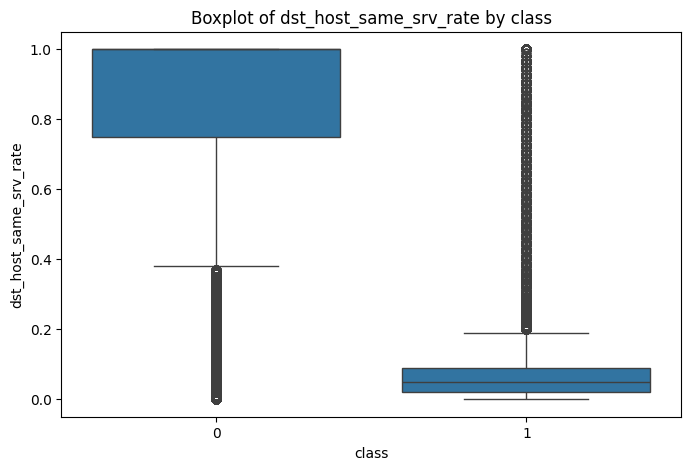

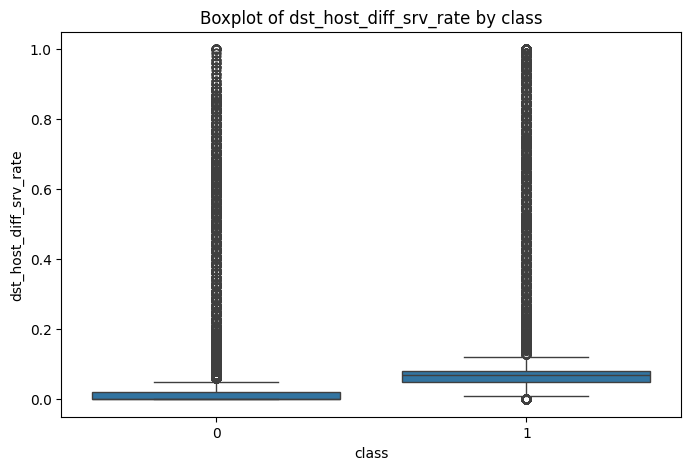

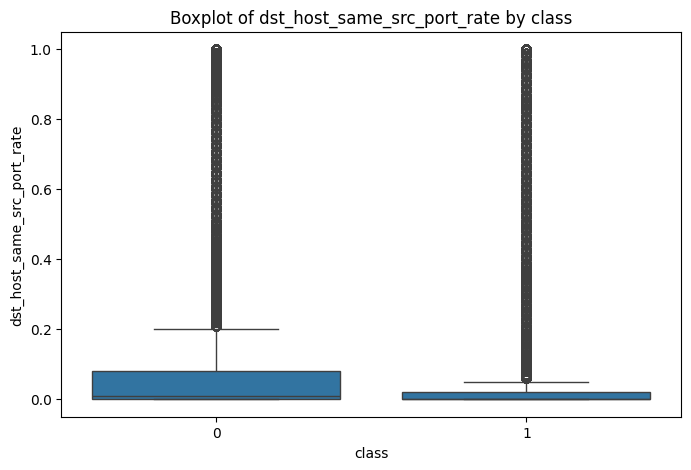

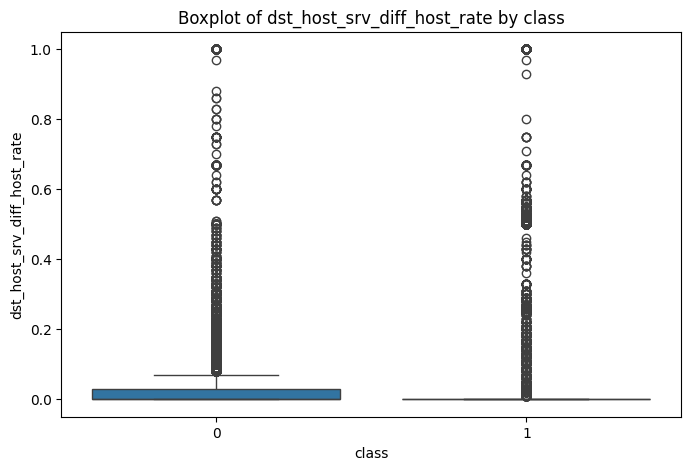

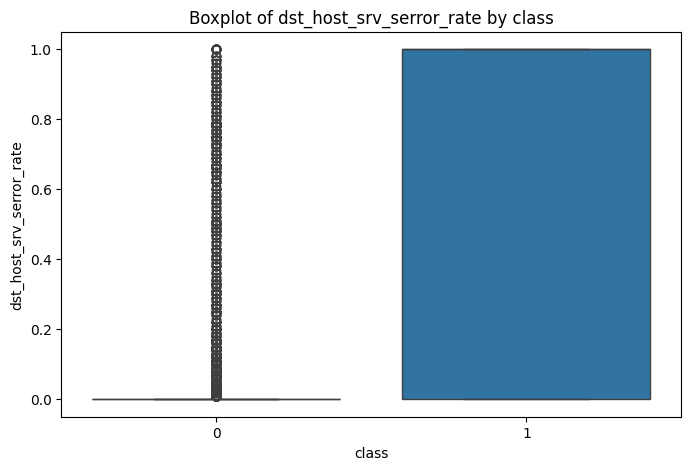

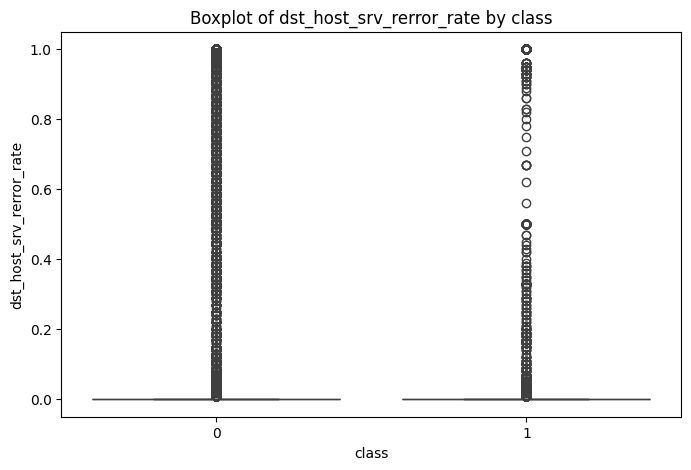

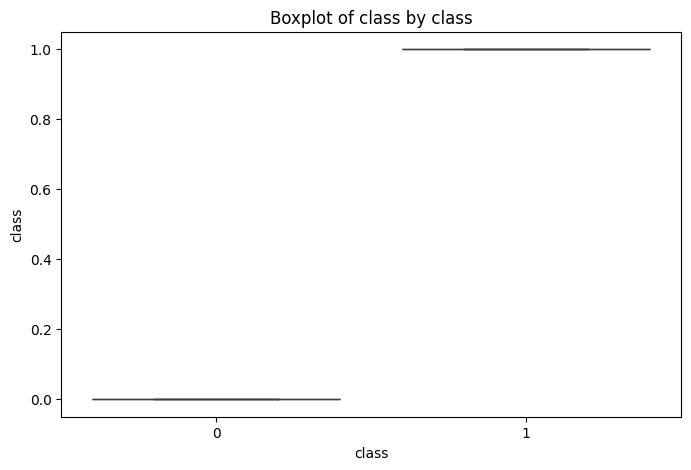

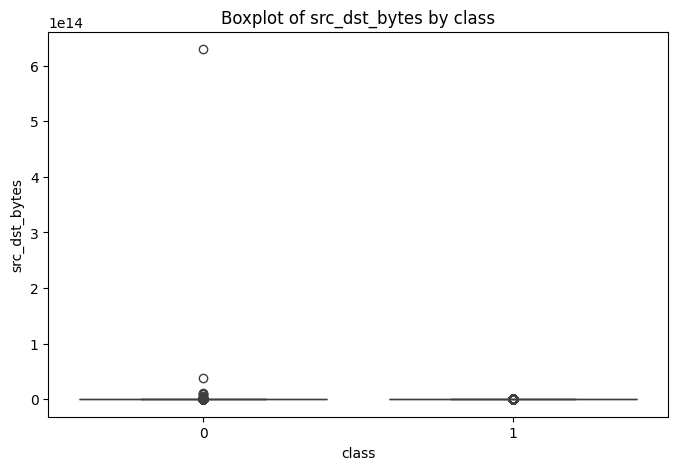

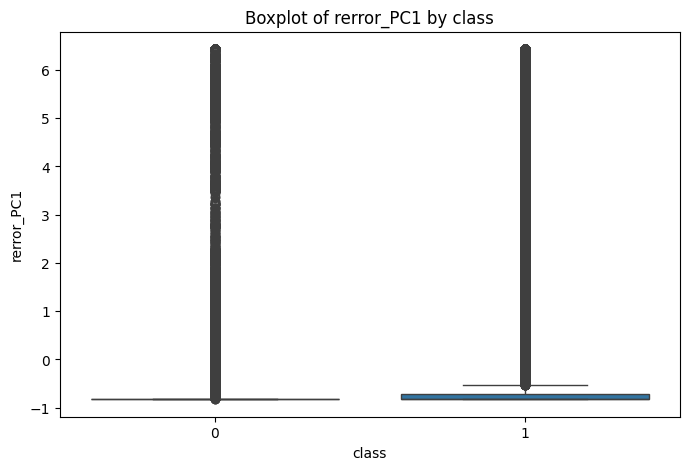

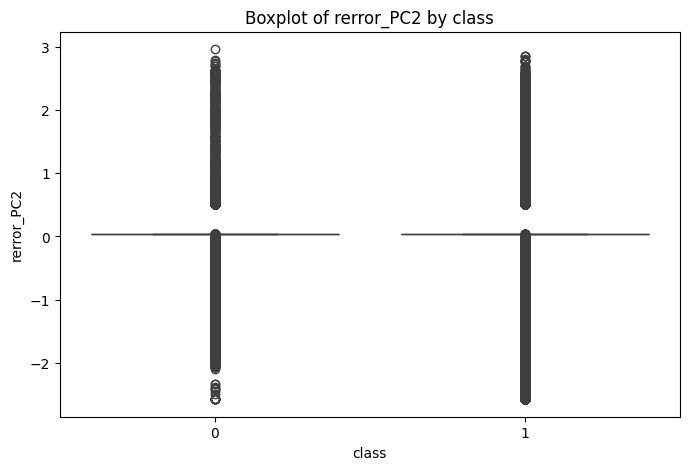

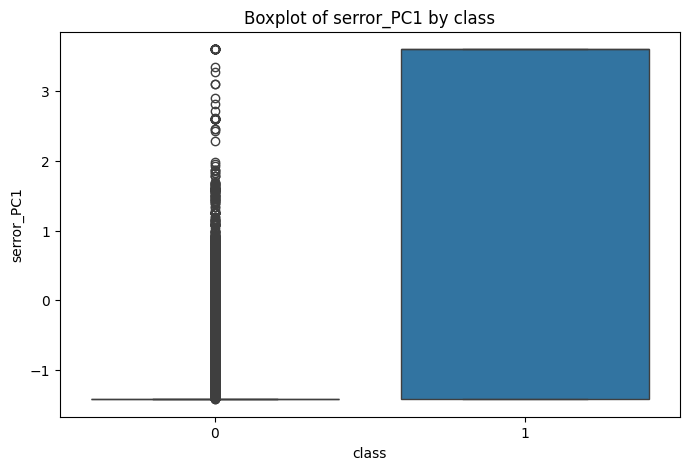

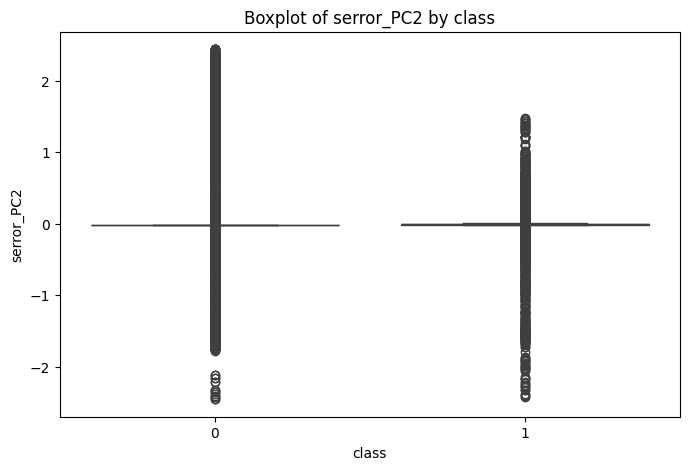

In [46]:
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='class', y=col, data=df_encoded)
    plt.title(f'Boxplot of {col} by class')
    plt.show()


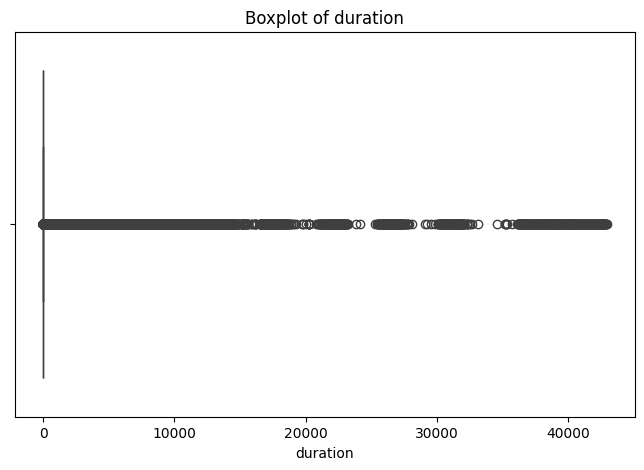

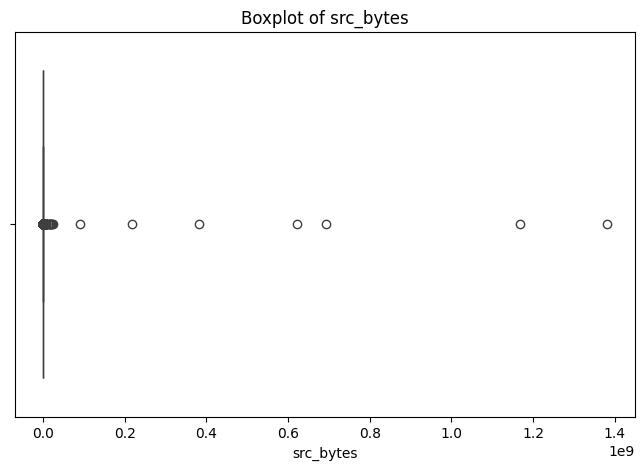

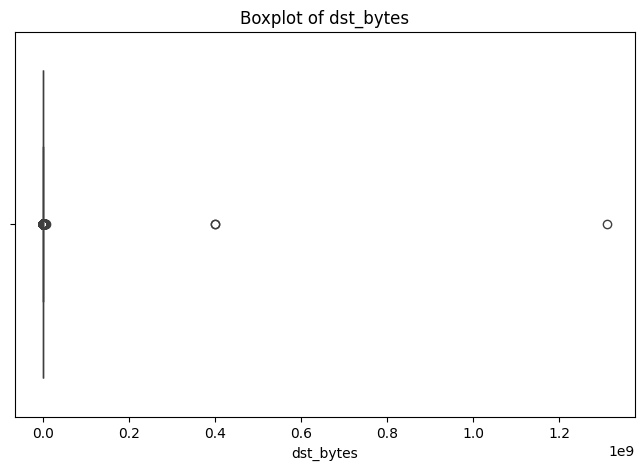

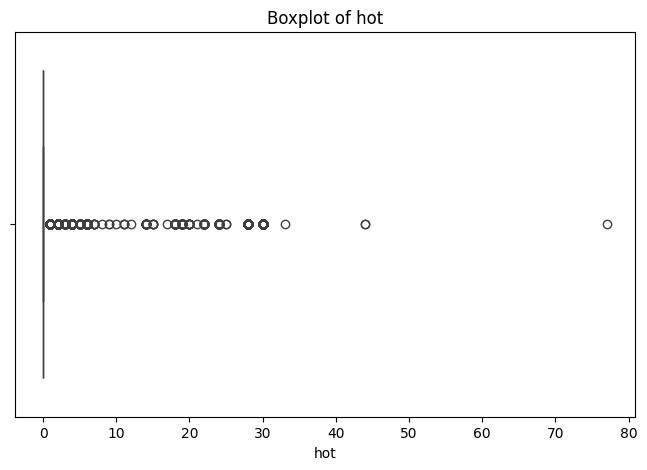

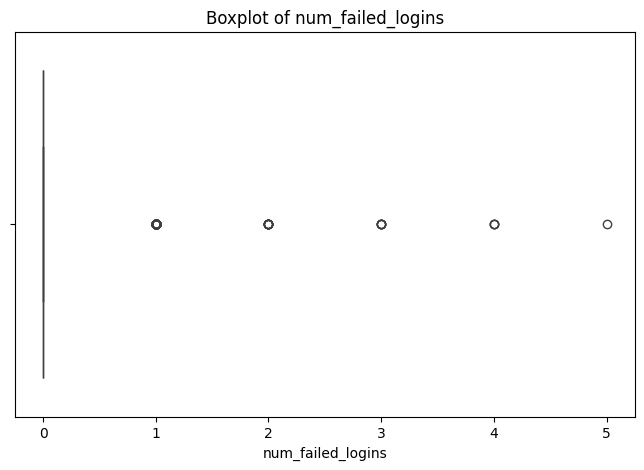

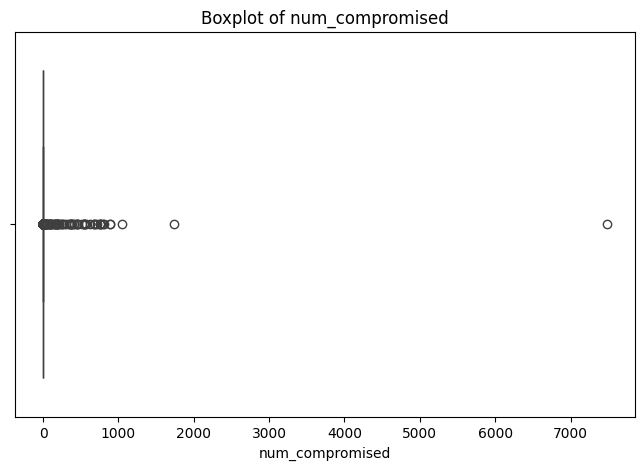

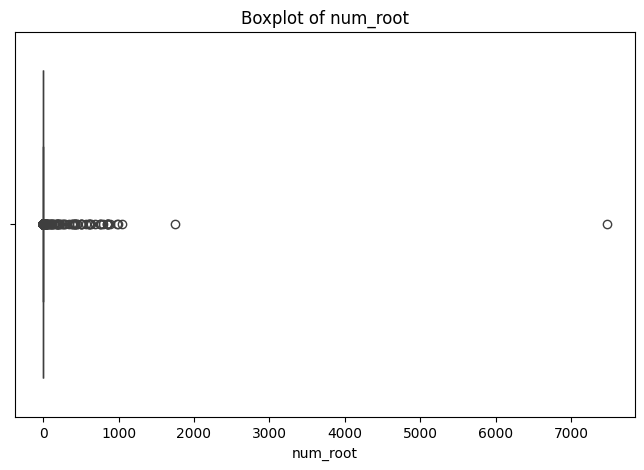

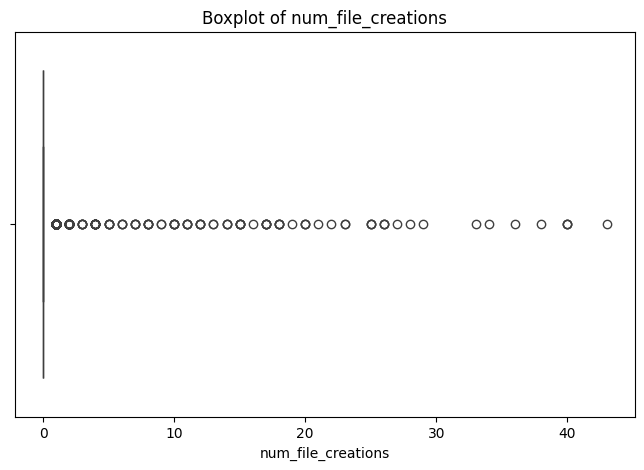

In [47]:
columns_obs = ['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'num_compromised','num_root',
'num_file_creations']

for col in columns_obs:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=col, data=df_encoded)
    plt.title(f'Boxplot of {col}')
    plt.show()

In [48]:
columns_obs = ['num_root', 'num_compromised', 'num_failed_logins', 'hot', 'src_bytes', 'dst_bytes', 'num_file_creations']

# give me counts in each qauntile in each column 
for col in columns_obs:
    quantiles = df_encoded[col].quantile([0.25, 0.5, 0.75])
    print(f"Quantiles for {col}:")
    print(quantiles)
    print("\nCounts in each quantile:")
    print(pd.cut(df_encoded[col], 
             bins=[-np.inf, quantiles[0.25], quantiles[0.5], quantiles[0.75], np.inf], 
             duplicates='drop').value_counts())
    print("\n")
  

Quantiles for num_root:
0.25    0.0
0.50    0.0
0.75    0.0
Name: num_root, dtype: float64

Counts in each quantile:
num_root
(-inf, 0.0]    125324
(0.0, inf]        649
Name: count, dtype: int64


Quantiles for num_compromised:
0.25    0.0
0.50    0.0
0.75    0.0
Name: num_compromised, dtype: float64

Counts in each quantile:
num_compromised
(-inf, 0.0]    124687
(0.0, inf]       1286
Name: count, dtype: int64


Quantiles for num_failed_logins:
0.25    0.0
0.50    0.0
0.75    0.0
Name: num_failed_logins, dtype: float64

Counts in each quantile:
num_failed_logins
(-inf, 0.0]    125851
(0.0, inf]        122
Name: count, dtype: int64


Quantiles for hot:
0.25    0.0
0.50    0.0
0.75    0.0
Name: hot, dtype: float64

Counts in each quantile:
hot
(-inf, 0.0]    123302
(0.0, inf]       2671
Name: count, dtype: int64


Quantiles for src_bytes:
0.25      0.0
0.50     44.0
0.75    276.0
Name: src_bytes, dtype: float64

Counts in each quantile:
src_bytes
(-inf, 0.0]      49392
(276.0, inf]     

### Count Plots

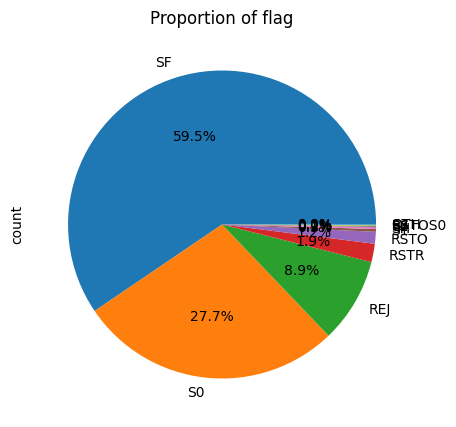

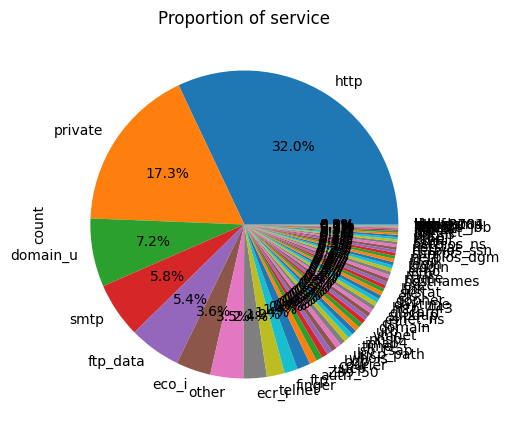

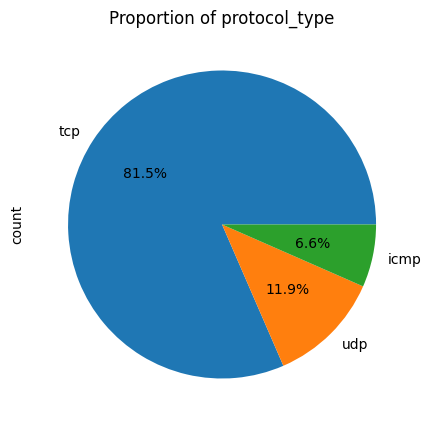

In [49]:
columns_obs = ['flag','service','protocol_type']
for col in columns_obs:
    plt.figure(figsize=(5, 5))
    df[col].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f'Proportion of {col}')
    plt.show()

### Line Plots

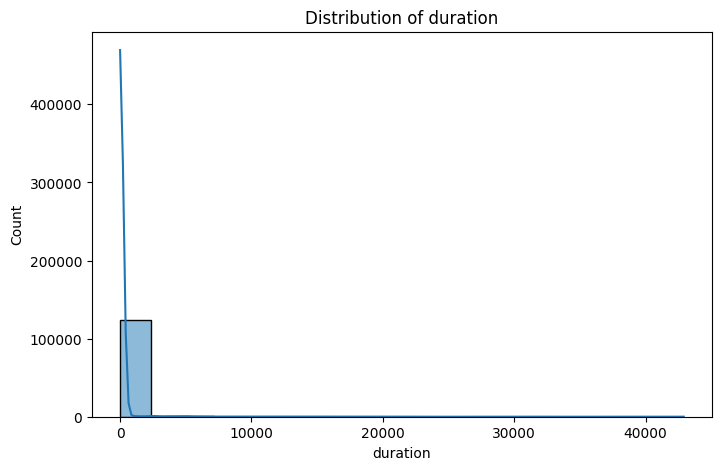

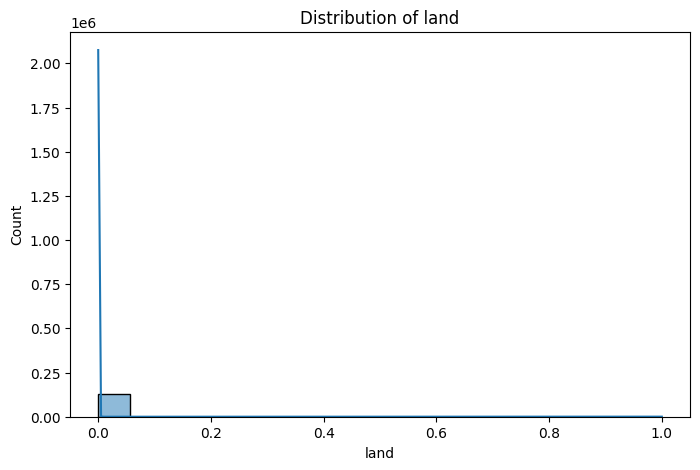

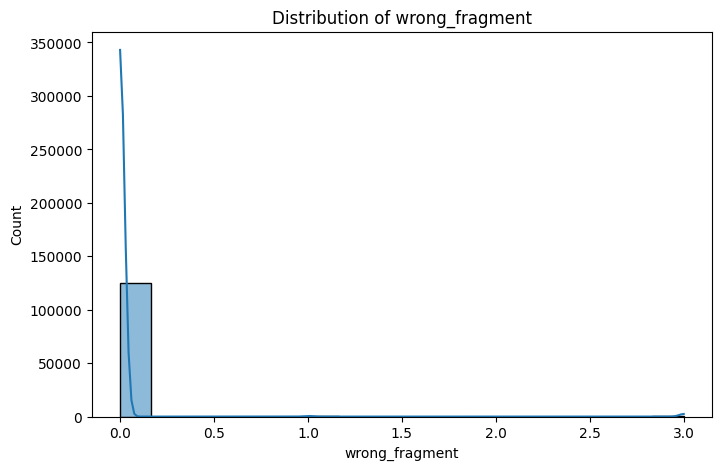

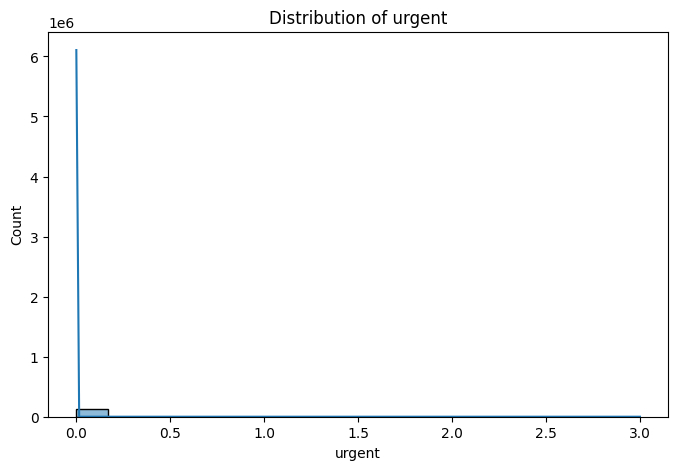

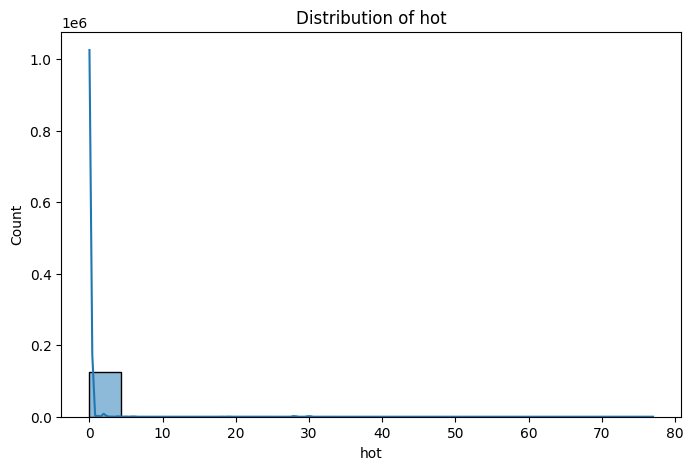

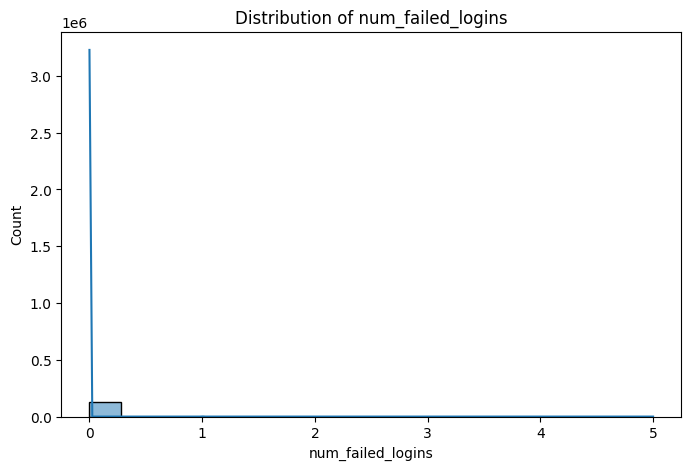

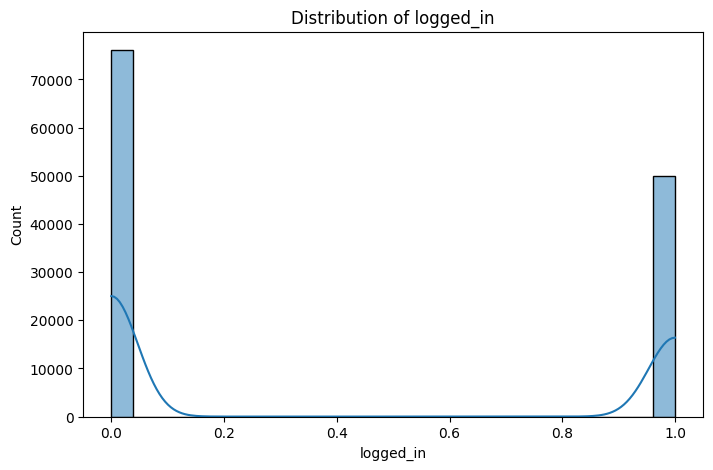

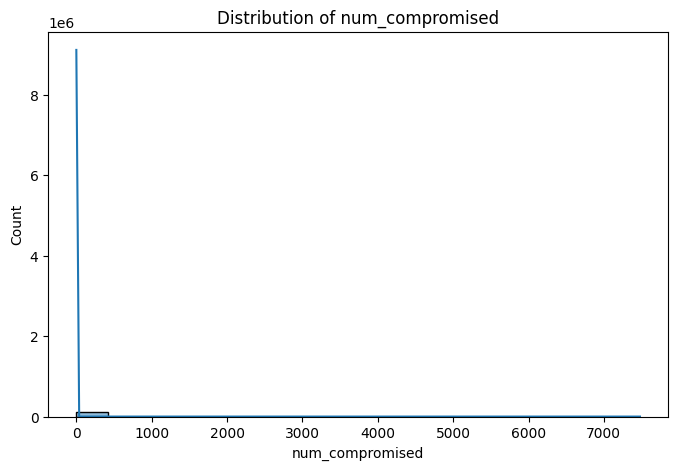

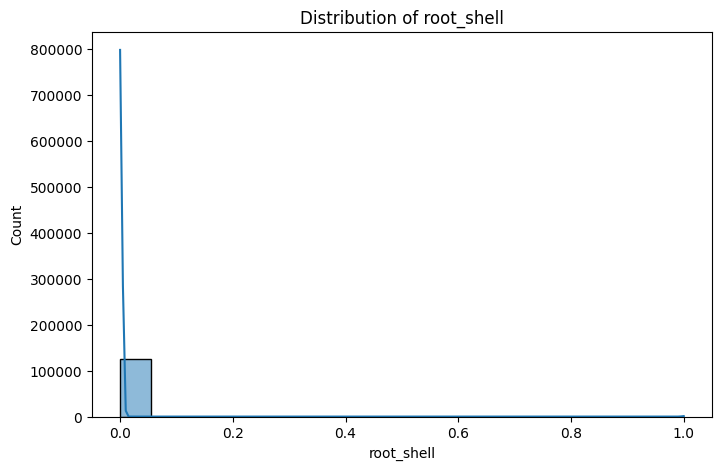

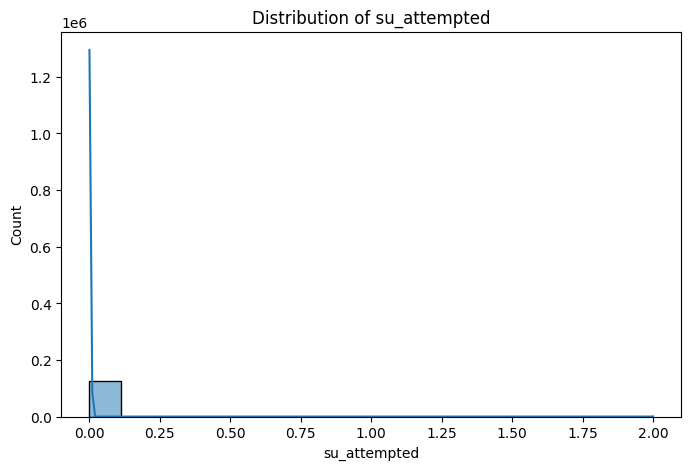

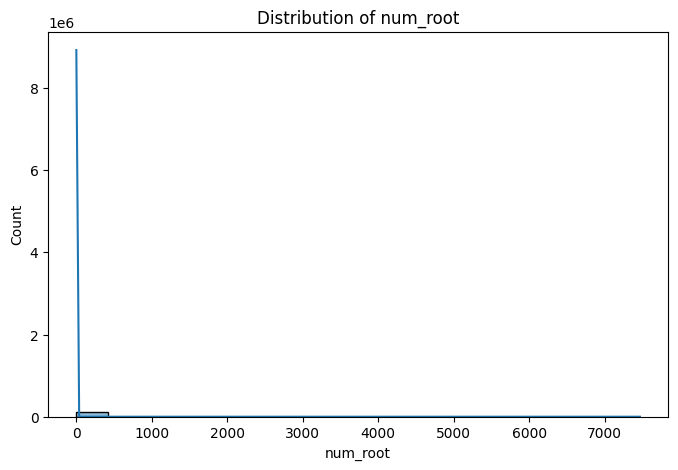

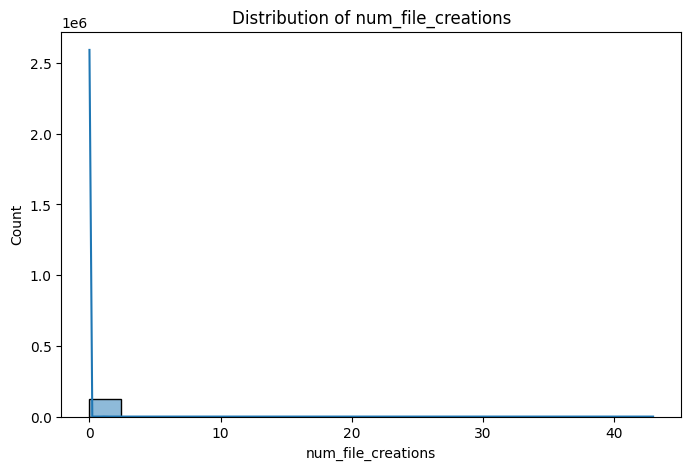

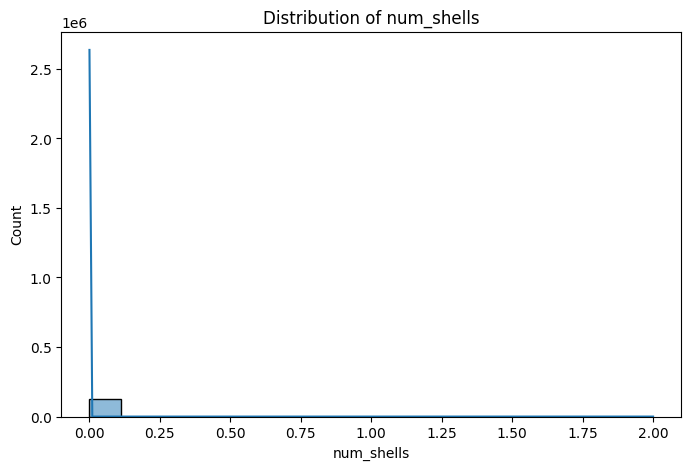

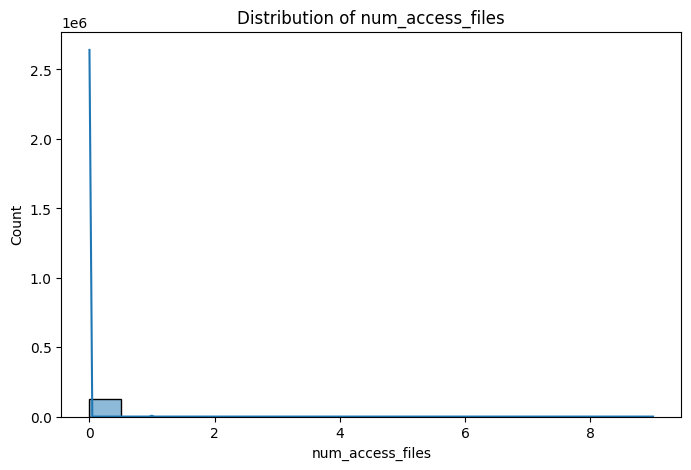

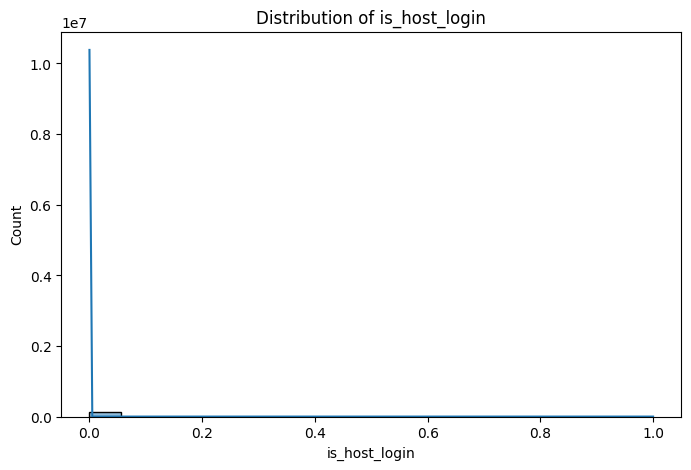

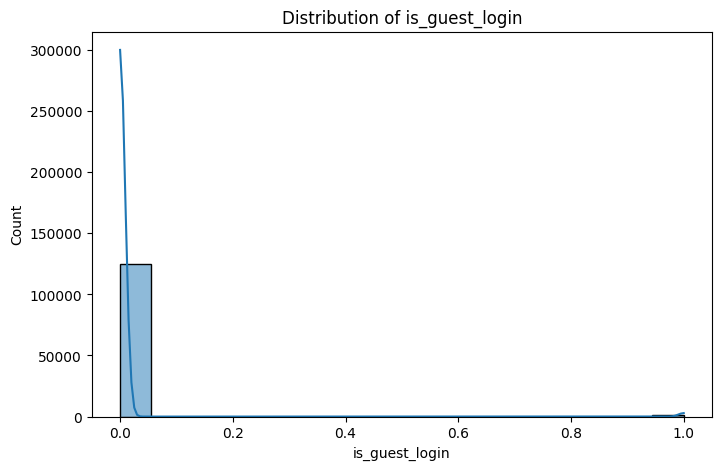

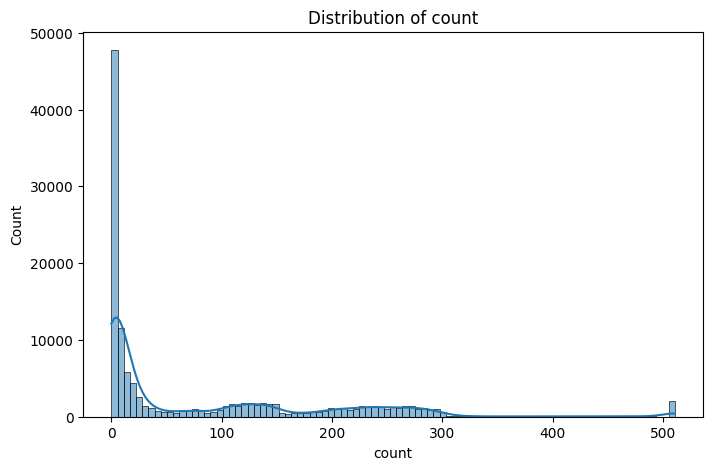

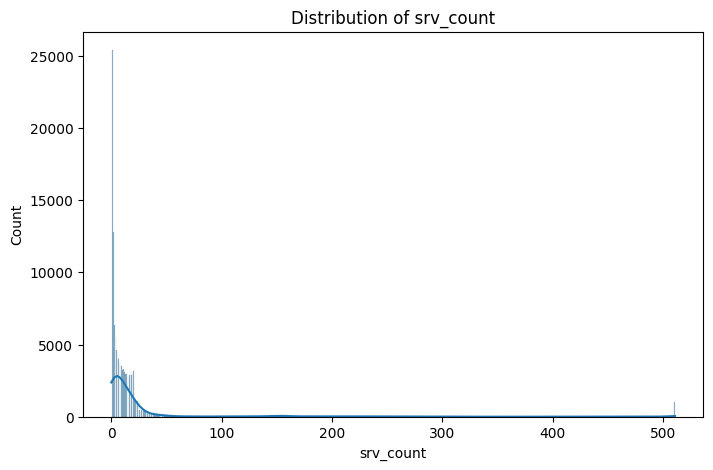

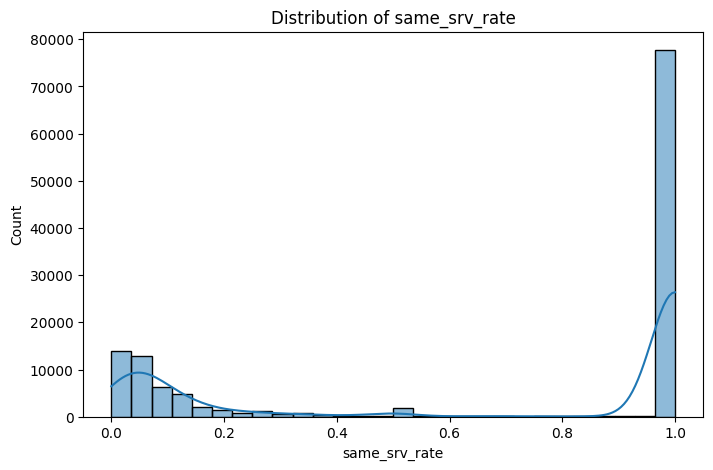

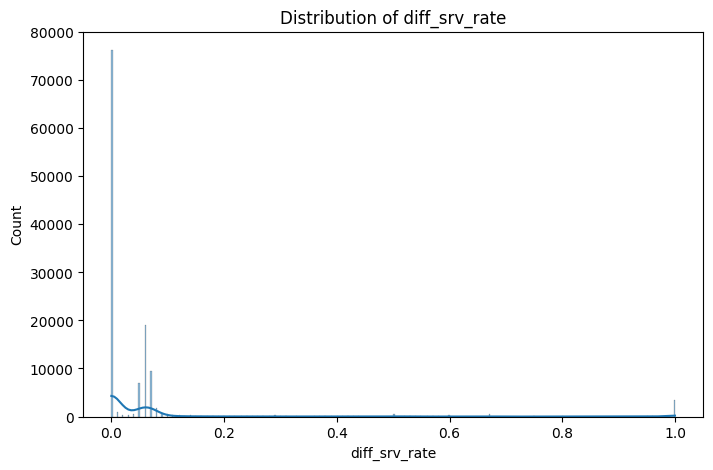

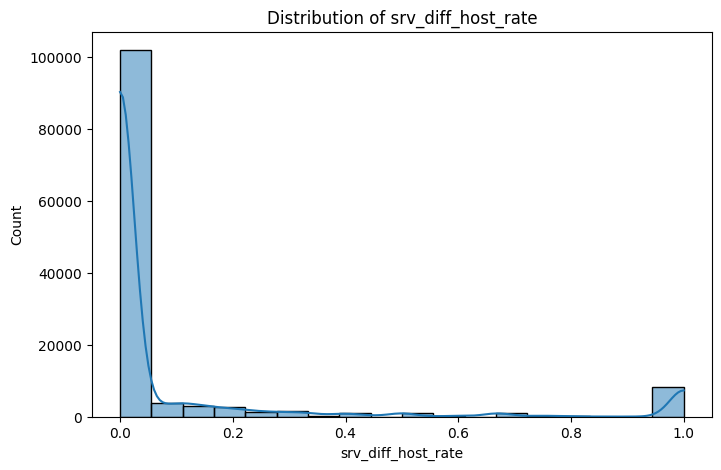

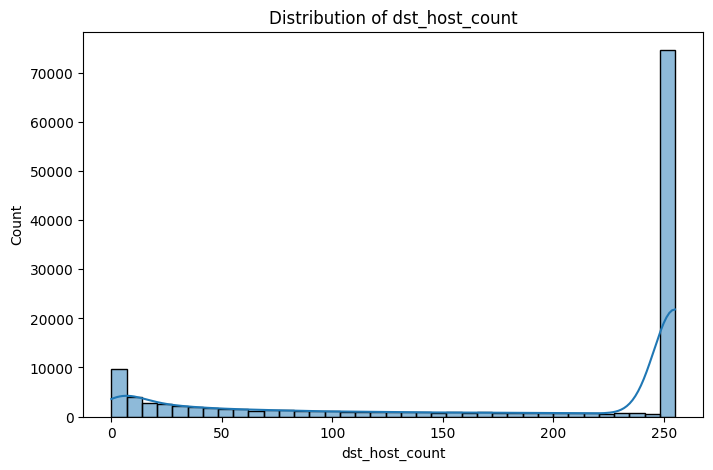

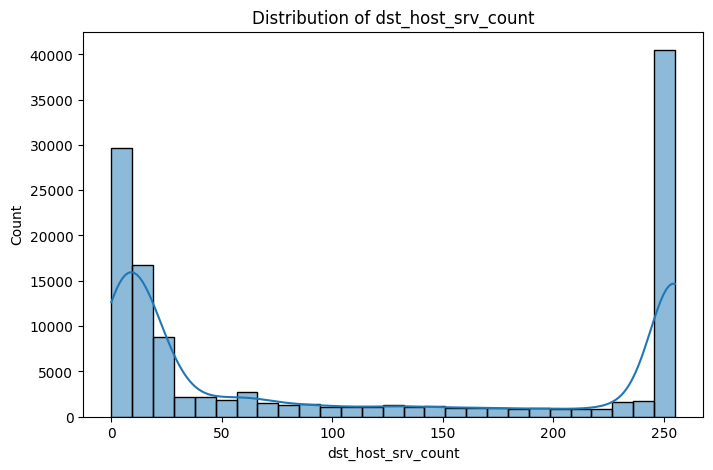

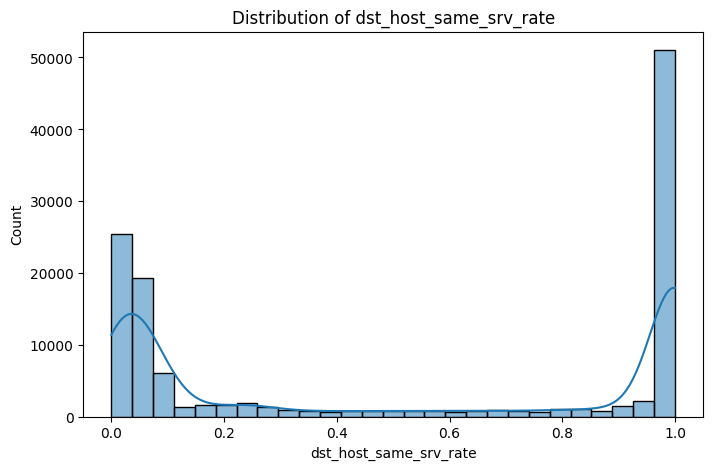

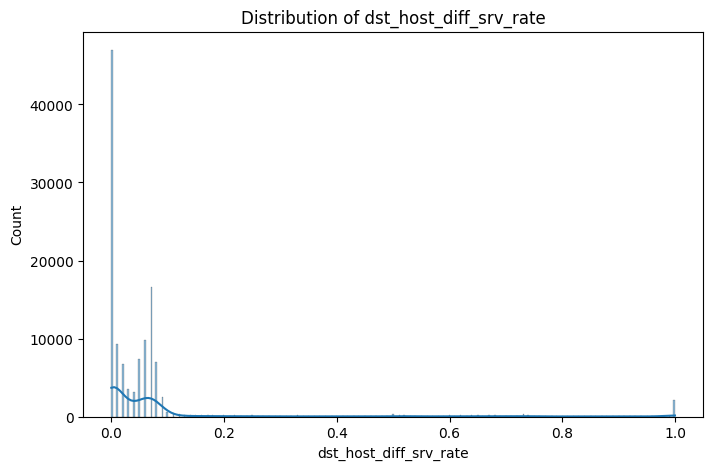

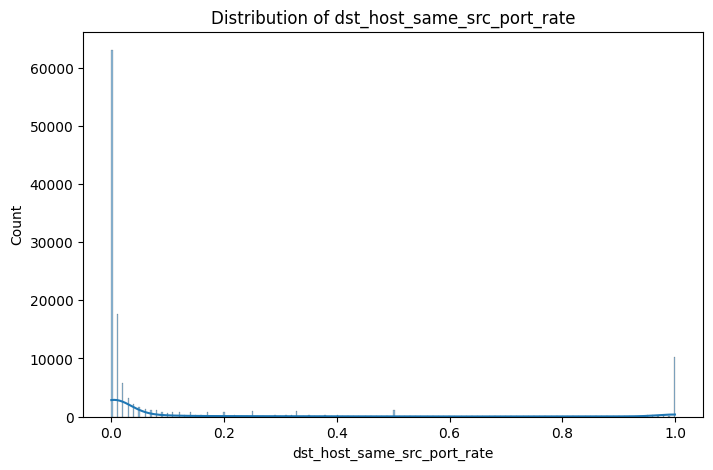

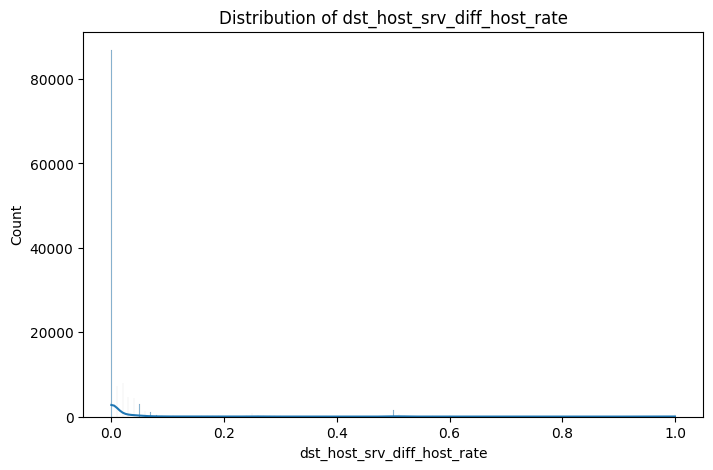

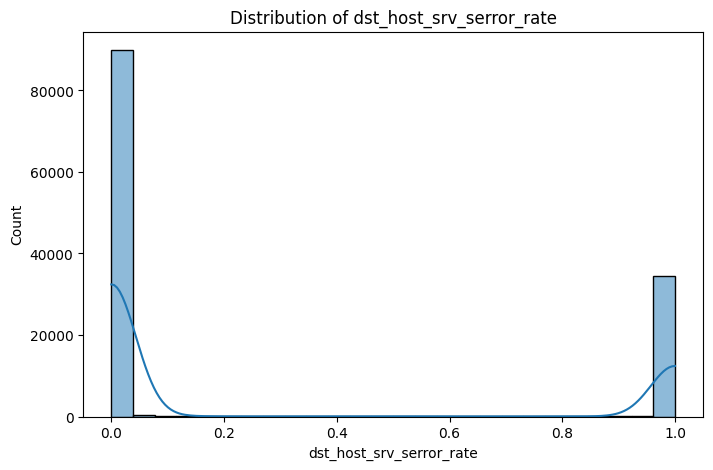

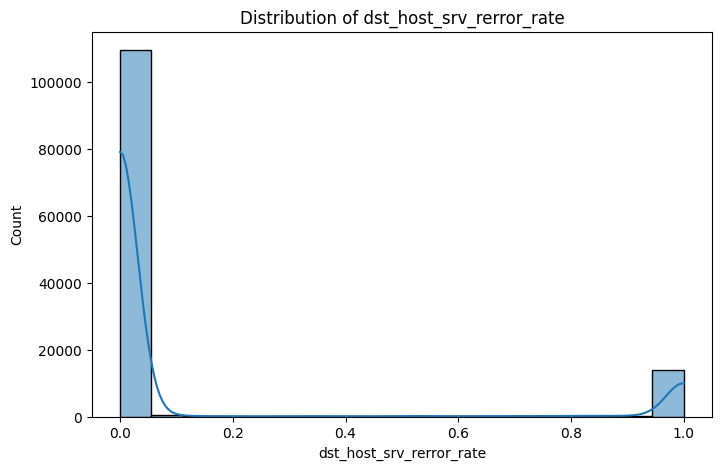

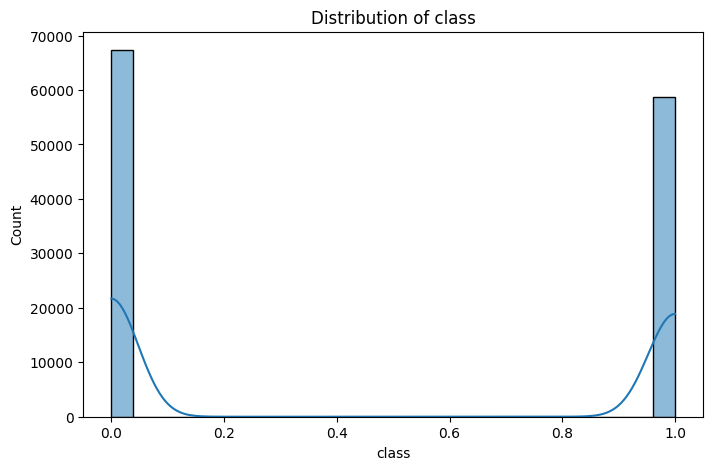

In [50]:
numeric_cols = ['duration',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_srv_serror_rate',
 'dst_host_srv_rerror_rate',
 'class']
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_encoded[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()